# Flat Gaussian with compositional score matching


In this notebook, we will use the compositional score matching to learn the posterior of a flat Gaussian model.
The problem is defined as follows:
- The prior is a Gaussian distribution with mean 0 and standard deviation 0.1.
- The simulator/likelihood is a Gaussian distribution with mean 0 and standard deviation 0.1.
- We have an analytical solution for the posterior.
- We set the dimension of the problem to $D=10$.

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from bayesflow import diagnostics
from torch.utils.data import DataLoader

from diffusion_model import CompositionalScoreModel, SDE, weighting_function, train_score_model, euler_maruyama_sampling, adaptive_sampling, probability_ode_solving, langevin_sampling, generate_diffusion_time, count_parameters
from problems.gaussian_flat import GaussianProblem, Prior, Simulator, visualize_simulation_output, generate_synthetic_data, \
    sample_posterior, posterior_contraction

In [ ]:
torch_device = torch.device("cpu")

In [ ]:
prior = Prior()
simulator_test = Simulator()

# test the simulator
prior_test = prior.sample(2)
sim_test = simulator_test(prior_test, n_obs=1000)
visualize_simulation_output(sim_test['observable'])

In [ ]:
batch_size = 128
max_number_of_obs = 1  # larger than one means we condition the score on multiple observations

dataset = GaussianProblem(
    n_data=10000,
    prior=prior,
    online_learning=True,
    max_number_of_obs=max_number_of_obs
)
dataset_valid = GaussianProblem(
    n_data=batch_size*2,
    prior=prior,
    max_number_of_obs=max_number_of_obs
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [ ]:
# Define diffusion model
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][0]
)

score_model = CompositionalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_x=prior.D,
    hidden_dim=128,
    n_blocks=3,
    max_number_of_obs=max_number_of_obs,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    time_embed_dim=16,
    use_film=False,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior
)

print(score_model.name)
count_parameters(score_model)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

In [ ]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 epochs=500, lr=1e-4, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Mean Train')
plt.plot(loss_history[:, 1], label='Mean Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')
plt.show()

In [ ]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", weights_only=True))
score_model.eval();

## Visualize Loss

In [ ]:
# check the error prediction: is it close to the noise?
loss_list_target = {}
loss_list_score = {}
loss_list_error_w_global = {}
loss_list_error = {}

with torch.no_grad():
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=100, device=torch_device)
    for t in diffusion_time:
        loss_list_target[t.item()] = 0
        loss_list_score[t.item()] = 0
        loss_list_error_w_global[t.item()] = 0
        loss_list_error[t.item()] = 0

        for theta_global_batch, _, x_batch in dataloader_valid:
            theta_global_batch = theta_global_batch.to(torch_device)
            x_batch = x_batch.to(torch_device)

            # sample from the Gaussian kernel, just learn the noise
            epsilon_global = torch.randn_like(theta_global_batch, dtype=torch.float32, device=torch_device)

            # perturb the theta batch
            t_tensor = torch.full((theta_global_batch.shape[0], 1), t,
                                  dtype=torch.float32, device=torch_device)
            # perturb the theta batch
            alpha, sigma = score_model.sde.kernel(t=t_tensor)
            snr = torch.log(torch.square(alpha)) - torch.log(torch.square(sigma))
            z_global = alpha * theta_global_batch + sigma * epsilon_global

            # predict from perturbed theta
            pred_epsilon_global = score_model(theta_global=z_global, time=t_tensor, x=x_batch, pred_score=False)
            pred_score_global = score_model(theta_global=z_global, time=t_tensor, x=x_batch, pred_score=True)
            true_score_global = score_model.sde.grad_log_kernel(x=z_global,
                                                                x0=theta_global_batch, t=t_tensor)

            if score_model.prediction_type == 'score':
                target_global = -epsilon_global / sigma
                pred_target_global = -pred_epsilon_global / sigma
            elif score_model.prediction_type == 'e':
                target_global = epsilon_global
                pred_target_global = pred_epsilon_global
            elif score_model.prediction_type == 'v':
                target_global = alpha*epsilon_global - sigma * theta_global_batch
                pred_target_global = alpha*pred_epsilon_global - sigma * theta_global_batch
            elif score_model.prediction_type == 'x':
                target_global = theta_global_batch
                pred_target_global = (z_global - pred_epsilon_global * sigma) / alpha
            else:
                raise ValueError("Invalid prediction type.")

            # calculate the loss (sum over the last dimension, mean over the batch)
            loss_global = torch.mean(torch.sum(torch.square(pred_target_global - target_global), dim=-1))
            loss = loss_global
            loss_list_target[t.item()] += loss.item()

            # calculate the error of the true score
            loss_global = torch.mean(torch.sum(torch.square(pred_score_global - true_score_global), dim=-1))
            loss = loss_global
            loss_list_score[t.item()] += loss.item()

            # calculate the weighted loss
            w = weighting_function(t_tensor, sde=score_model.sde,
                                   weighting_type=score_model.weighting_type, prediction_type=score_model.prediction_type)
            loss_global = torch.mean(w * torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss_list_error_w_global[t.item()] += loss_global.item()

            # check if the weighting function is correct
            loss_global = torch.mean(torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss = loss_global
            loss_list_error[t.item()] += loss.item()

In [ ]:
df_target = pd.DataFrame(loss_list_target.items(), columns=['Time', 'Loss'])
df_score = pd.DataFrame(loss_list_score.items(), columns=['Time', 'Loss'])
df_error_w_global = pd.DataFrame(loss_list_error_w_global.items(), columns=['Time', 'Loss'])
df_error = pd.DataFrame(loss_list_error.items(), columns=['Time', 'Loss'])

# compute snr
snr = score_model.sde.get_snr(diffusion_time)
#upper_bound_loss = (np.sqrt(2) + 1) / (std.numpy()**2)

fig, ax = plt.subplots(ncols=4, sharex=True, figsize=(16, 3), tight_layout=True)
ax[0].plot(df_target['Time'], np.log(df_target['Loss']), label=f'Unscaled {score_model.prediction_type} Loss')
ax[1].plot(df_score['Time'], np.log(df_score['Loss']), label='Score Loss')
#ax[1].plot(df_score['Time'], df_score['Loss'] / upper_bound_loss, label='Score Loss')
ax[1].plot(diffusion_time, snr, label='log snr', alpha=0.5)
ax[2].plot(df_error_w_global['Time'], np.log(df_error_w_global['Loss']), label='Weighted Loss (as in Optimization)')
ax[3].plot(df_error['Time'], np.log(df_error['Loss']), label='Loss on Error')
for a in ax:
    a.set_xlabel('Diffusion Time')
    a.set_ylabel('Log Loss')
    a.legend()
plt.savefig(f'plots/{score_model.name}/losses_diffusion_time.png')
plt.show()

plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(diffusion_time.cpu(),
         weighting_function(diffusion_time, sde=score_model.sde, weighting_type=score_model.weighting_type,
                            prediction_type=score_model.prediction_type).cpu(),
         label='weighting')
plt.xlabel('Diffusion Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Validation

In [ ]:
data_size = 10  # number of observations
valid_prior_global, valid_data = generate_synthetic_data(prior, n_samples=100, data_size=data_size,
                                                         normalize=False, random_seed=0)
param_names = ['$D_{' + str(i+1) + '}$' for i in range(prior.D)]
n_post_samples = 100
#score_model.current_number_of_obs = 1

In [ ]:
visualize_simulation_output(valid_data)

In [ ]:
sample_posterior_single = lambda vd: sample_posterior(
    vd,
    prior_sigma=prior.scale,
    sigma=prior.simulator.scale,
    n_samples=n_post_samples
)
posterior_global_samples_true = np.array([sample_posterior_single(vd) for vd in valid_data])

In [ ]:
diagnostics.plot_recovery(posterior_global_samples_true, np.array(valid_prior_global), param_names=param_names)
diagnostics.plot_sbc_ecdf(posterior_global_samples_true, np.array(valid_prior_global),
                          difference=True, param_names=param_names);

In [ ]:
posterior_global_samples_valid = np.array([langevin_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                             #n_scores_update=10,
                                                            diffusion_steps=300, langevin_steps=5, step_size_factor=0.05,
                                           device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_langevin_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_langevin_sampler.png')

In [ ]:
posterior_global_samples_valid = np.array([euler_maruyama_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                                   #n_scores_update=10,
                                                                   diffusion_steps=1000, device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sampler.png')

In [ ]:
posterior_global_samples_valid = np.array([euler_maruyama_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                                   n_scores_update=10,
                                                                   diffusion_steps=200, device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sub_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sub_sampler.png')

In [ ]:
posterior_global_samples_valid = np.array([adaptive_sampling(score_model, vd, n_post_samples,
                                                             e_abs=1.,
                                                             #n_scores_update=10,
                                                             device=torch_device)
                                        for vd in valid_data])

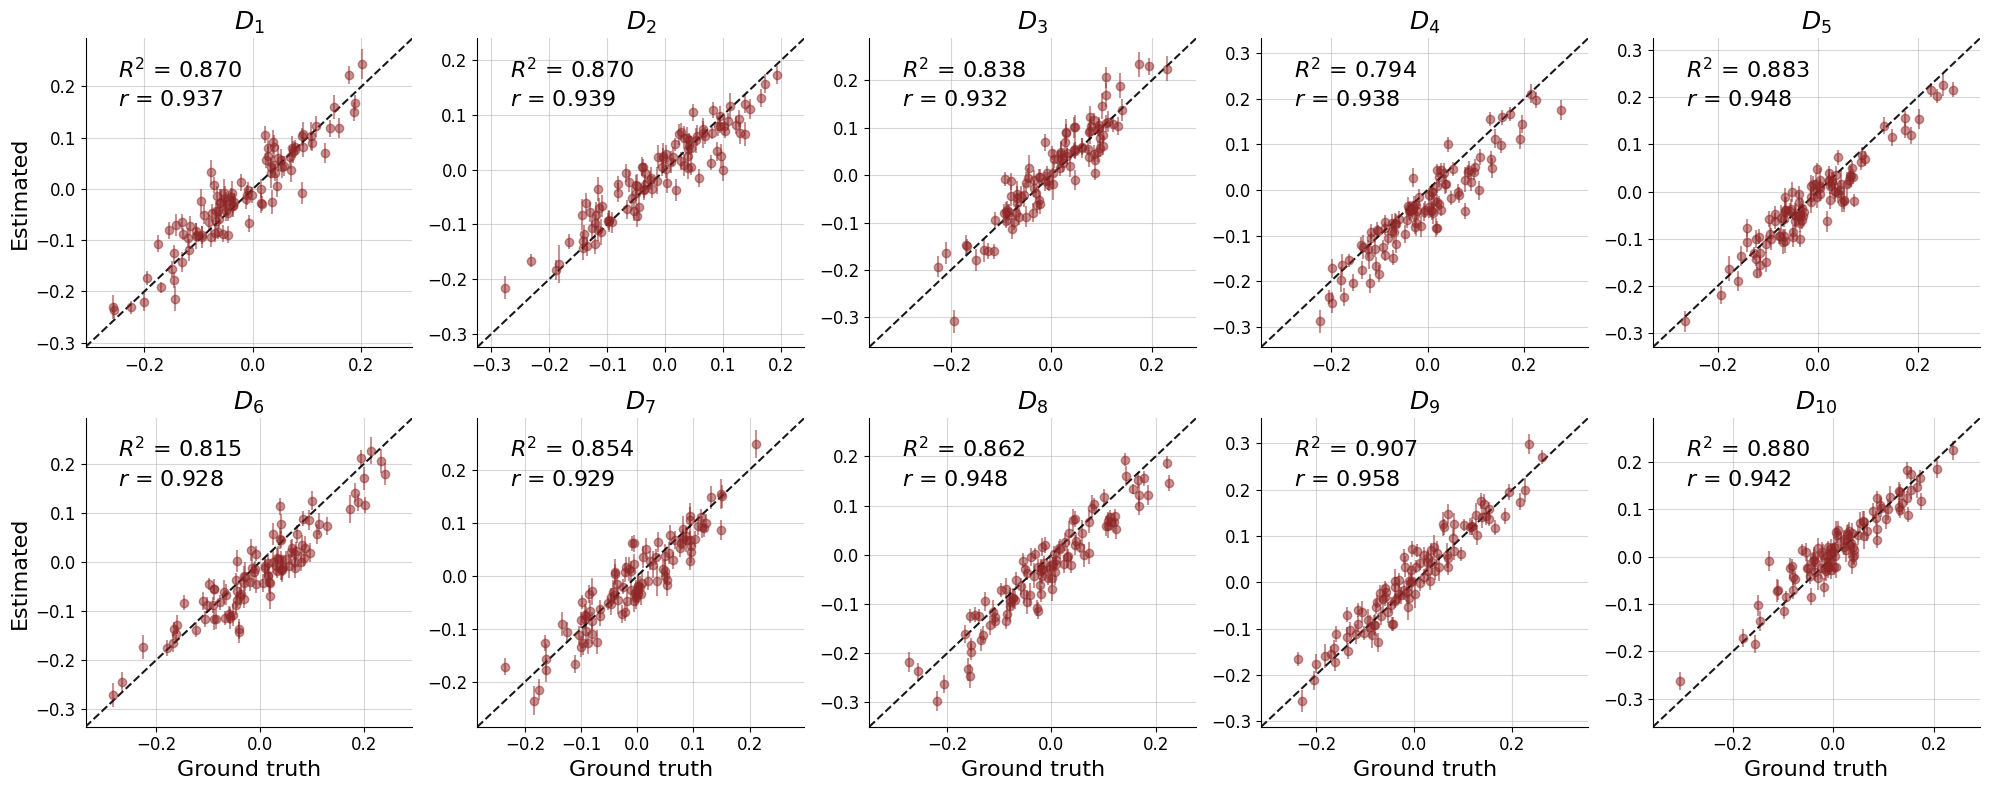

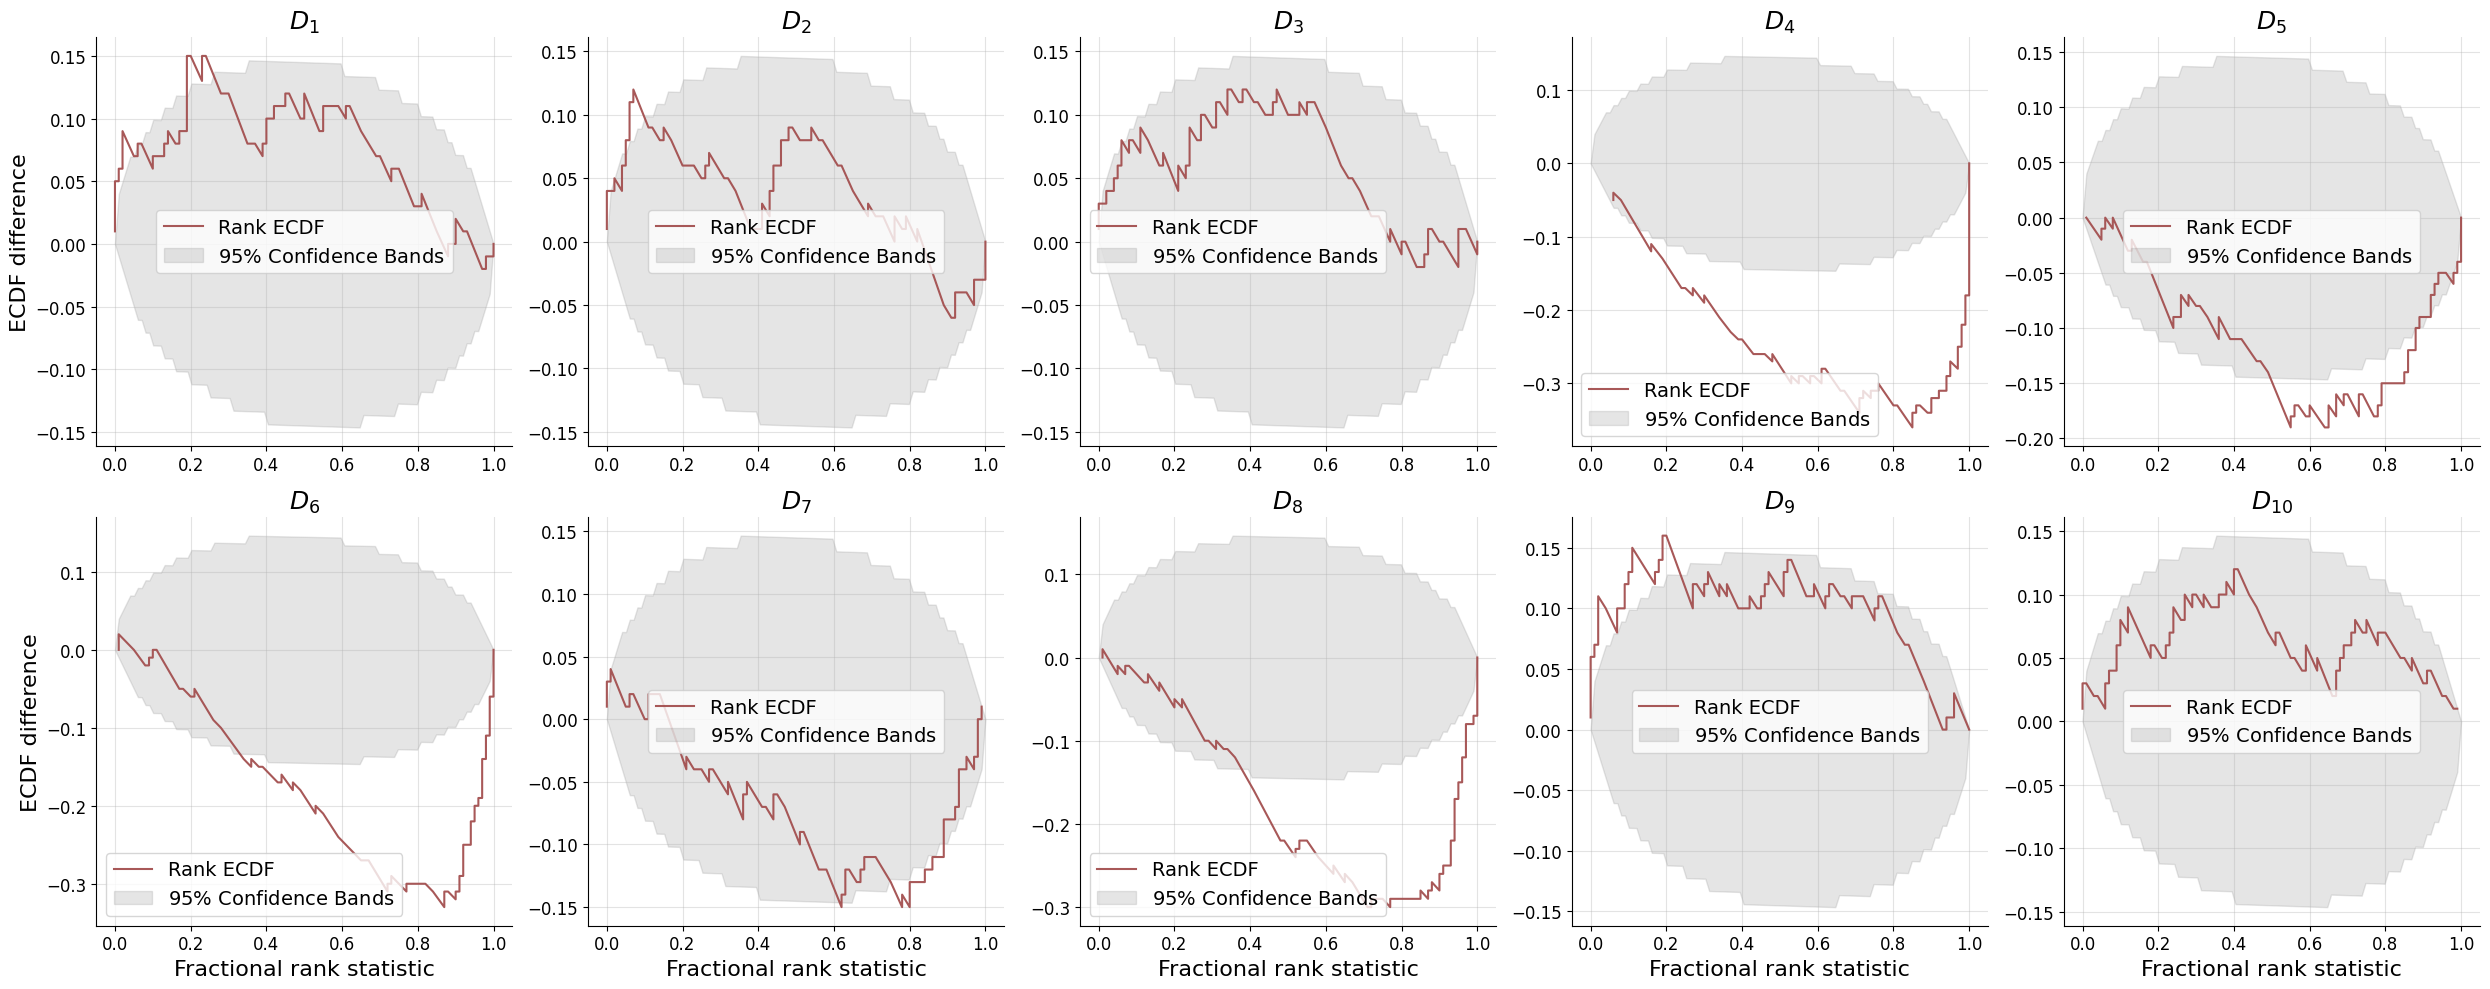

In [59]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_adaptive_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_adaptive_sampler.png')

In [ ]:
posterior_global_samples_valid = np.zeros((len(valid_data), n_post_samples, 2))
for i, vd in enumerate(valid_data):
    # solve for every sample individually, much slower, and still most of the samples were similar
    #for j in range(n_post_samples):
    #    posterior_global_samples_valid[i, j] = probability_ode_solving(score_model, vd, n_post_samples=1,
    #                                                                    device=torch_device)
    # solve for all samples at once
    posterior_global_samples_valid[i] = probability_ode_solving(score_model, vd, n_post_samples=n_post_samples,
                                                                #n_scores_update=10,
                                                                device=torch_device)

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_ode.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_ode.png')

# Step Size for different Grid Sizes

In [63]:
# check number of steps needed for different number of data points
n_steps = {}
n_steps_per_grid = {}
n_steps_error = {}
#score_model.current_number_of_obs = 1

valid_id = 0
data_sizes = np.array([1, 10, 100, 1000]) * score_model.current_number_of_obs
sampling_types = [('normal', None, 0.), ('subsample', 10, 0.)]

for sampling_type in sampling_types:
    print(sampling_type)
    n_steps[sampling_type[0]] = []
    n_steps_per_grid[sampling_type[0]] = []
    n_steps_error[sampling_type[0]] = []
    for n in data_sizes:
        true_params, valid_data = generate_synthetic_data(prior, n_samples=10, data_size=n,
                                                   normalize=False, random_seed=0)
        x_valid = valid_data[valid_id].to(torch_device)
        test_sample, list_steps = adaptive_sampling(score_model, x_valid, conditions=None, n_post_samples=1,
                                                    n_scores_update=sampling_type[1],
                                                    t_end=0, random_seed=0, device=torch_device,
                                                    return_steps=True)

        n_steps_per_grid[sampling_type[0]].append(list_steps)
        n_steps[sampling_type[0]].append(len(list_steps))
        n_steps_error[sampling_type[0]].append(np.mean((test_sample-true_params[valid_id].numpy())**2))

('normal', None, 0.0)


  0%|          | 11/10000 [00:00<00:10, 992.07it/s]


Finished after 12 steps (24 score evals) at time 0.0.
Mean step size: 0.1111111119389534, min: 0.009999999776482582, max: 0.30638208985328674


  2%|▏         | 162/10000 [00:00<00:11, 885.49it/s]

Finished after 163 steps (326 score evals) at time 0.0.


Mean step size: 0.011904754675924778, min: 0.0036590558011084795, max: 0.07739696651697159


 17%|█▋        | 1721/10000 [00:02<00:13, 604.86it/s]


Finished after 1722 steps (3444 score evals) at time 0.0.
Mean step size: 0.001141553046181798, min: 0.00032804679358378053, max: 0.021005164831876755


100%|██████████| 10000/10000 [00:44<00:00, 226.57it/s]


Finished after 10000 steps (20000 score evals) at time 0.7536620497703552.
Mean step size: 4.904193338006735e-05, min: 2.8412503525032662e-05, max: 0.00011737972090486437
('subsample', 10, 0.0)


  0%|          | 10/10000 [00:00<00:08, 1121.86it/s]


Finished after 11 steps (22 score evals) at time 0.0.
Mean step size: 0.1111111268401146, min: 0.009999999776482582, max: 0.2850199043750763


  2%|▏         | 162/10000 [00:00<00:10, 899.98it/s]


Finished after 163 steps (326 score evals) at time 0.0.
Mean step size: 0.011764704249799252, min: 0.0036740589421242476, max: 0.0967288464307785


  2%|▏         | 158/10000 [00:00<00:08, 1115.35it/s]


Finished after 159 steps (318 score evals) at time 0.0.
Mean step size: 0.012195120565593243, min: 0.0039480323903262615, max: 0.08977527916431427


  1%|▏         | 141/10000 [00:00<00:09, 1074.71it/s]

Finished after 142 steps (284 score evals) at time 0.0.
Mean step size: 0.01298701111227274, min: 0.0038454642053693533, max: 0.08007169514894485


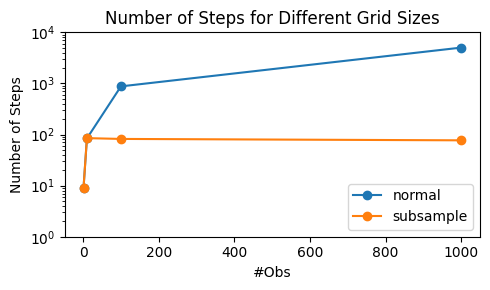

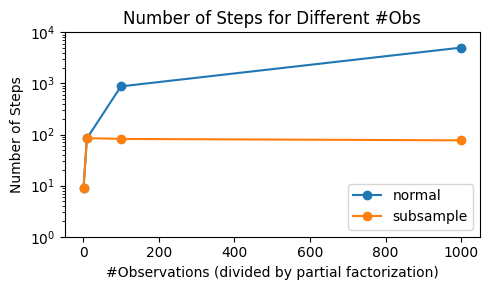

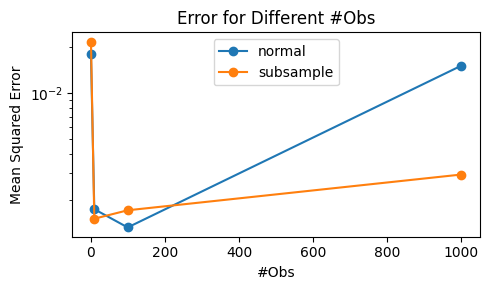

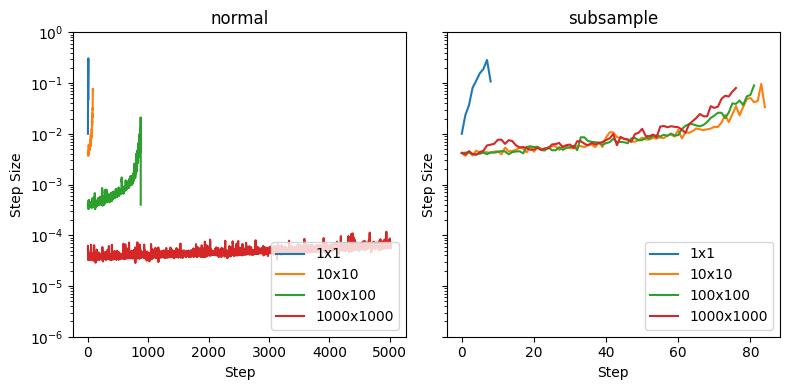

In [64]:
plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(data_sizes, n_steps[sampling_type[0]], 'o-', label=sampling_type[0])

if score_model.max_number_of_obs > 1:
    plt.title(f'Number of Steps for Different Grid Sizes ({score_model.current_number_of_obs} Obs)')
else:
    plt.title('Number of Steps for Different Grid Sizes')
plt.xlabel('#Obs')
plt.ylabel('Number of Steps')
plt.yscale('log')
plt.ylim(1, 1e4)
plt.legend()
plt.savefig(f'plots/{score_model.name}/number_of_steps_vs_grid_size{score_model.current_number_of_obs}.png')
plt.show()

plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(np.array(data_sizes)/score_model.current_number_of_obs,
             n_steps[sampling_type[0]], 'o-', label=sampling_type[0])

if score_model.max_number_of_obs > 1:
    plt.title(f'Number of Steps for Different #Obs ({score_model.current_number_of_obs} Obs)')
else:
    plt.title('Number of Steps for Different #Obs')
plt.xlabel('#Observations (divided by partial factorization)')
plt.ylabel('Number of Steps')
plt.yscale('log')
plt.ylim(1, 1e4)
plt.legend()
plt.savefig(f'plots/{score_model.name}/number_of_steps_vs_n_obs{score_model.current_number_of_obs}.png')
plt.show()

plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(data_sizes, n_steps_error[sampling_type[0]], 'o-', label=sampling_type[0])
plt.title('Error for Different #Obs')
plt.xlabel('#Obs')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.legend()
plt.savefig(f'plots/{score_model.name}/error_vs_grid_size{score_model.current_number_of_obs}.png')
plt.show()

fig, ax = plt.subplots(1, len(sampling_types), sharey=True, figsize=(4*len(sampling_types), 4), tight_layout=True)
for a, sampling_type in zip(ax, sampling_types):
    a.set_title(sampling_type[0])
    for i, n in zip(data_sizes, n_steps_per_grid[sampling_type[0]]):
        a.plot(n, label=f'{i}x{i}')
    a.set_xlabel('Step')
    a.set_ylabel('Step Size')
    a.set_yscale('log')
    a.legend(loc='lower right')
    a.set_ylim(1e-6, 1)
plt.savefig(f'plots/{score_model.name}/n_steps_per_grid{score_model.current_number_of_obs}.png')
plt.show()

# Contraction vs Subsampling

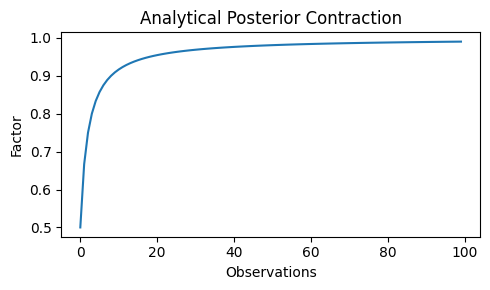

In [65]:
# plot contraction factor
prior_std = prior.scale
likelihood_std = prior.simulator.scale

# contraction =  1 - posterior_var / prior_var
contractions = [posterior_contraction(prior_std, likelihood_std, n).mean() for n in range(1, 101)]
plt.figure(figsize=(5, 3), tight_layout=True)
plt.plot(contractions)
plt.title('Analytical Posterior Contraction')
plt.xlabel('Observations')
plt.ylabel('Factor')
plt.show()

In [69]:
# check number of steps needed for different number of data points
posterior_var = {}
score_model.current_number_of_obs = 1

valid_id = 0
data_sizes = np.array([100])
sampling_types = [('normal', None),
                  ('subsample1', 1),
                  ('subsample2', 10),
                  ('subsample3', 25),
                  ('subsample4', 50)]

for sampling_type in sampling_types:
    print(sampling_type)
    posterior_var[sampling_type[0]] = []
    for n in data_sizes:
        true_params, valid_data = generate_synthetic_data(prior, n_samples=100, data_size=n,
                                                   normalize=False, random_seed=0)
        x_valid = valid_data[valid_id].to(torch_device)
        test_sample, list_steps = adaptive_sampling(score_model, x_valid, conditions=None, n_post_samples=20,
                                                    n_scores_update=sampling_type[1],
                                                    t_end=0, random_seed=0, device=torch_device,
                                                    return_steps=True)
        posterior_var[sampling_type[0]].append(np.var(test_sample, axis=0))

('normal', None, 0.0)


 89%|████████▉ | 1775/2000 [00:14<00:01, 125.73it/s]


Finished after 1776 steps (3552 score evals) at time 0.0.
Mean step size: 0.001119820517487824, min: 0.00038373531424440444, max: 0.022176025435328484
('subsample1', 1, 0.0)


  1%|          | 11/2000 [00:00<00:03, 634.49it/s]


Finished after 12 steps (24 score evals) at time 0.0.
Mean step size: 0.09090908616781235, min: 0.009999999776482582, max: 0.23628433048725128
('subsample2', 10, 0.0)


  9%|▉         | 175/2000 [00:00<00:04, 366.99it/s]


Finished after 176 steps (352 score evals) at time 0.0.
Mean step size: 0.011111109517514706, min: 0.0038467266131192446, max: 0.0672142505645752
('subsample3', 25, 0.0)


 23%|██▎       | 460/2000 [00:01<00:05, 282.31it/s]


Finished after 461 steps (922 score evals) at time 0.0.
Mean step size: 0.0043103452771902084, min: 0.0014827055856585503, max: 0.0398322157561779
('subsample4', 50, 0.0)


 46%|████▌     | 911/2000 [00:04<00:05, 183.21it/s]

Finished after 912 steps (1824 score evals) at time 0.0.
Mean step size: 0.002178649418056011, min: 0.000748374848626554, max: 0.02763817459344864


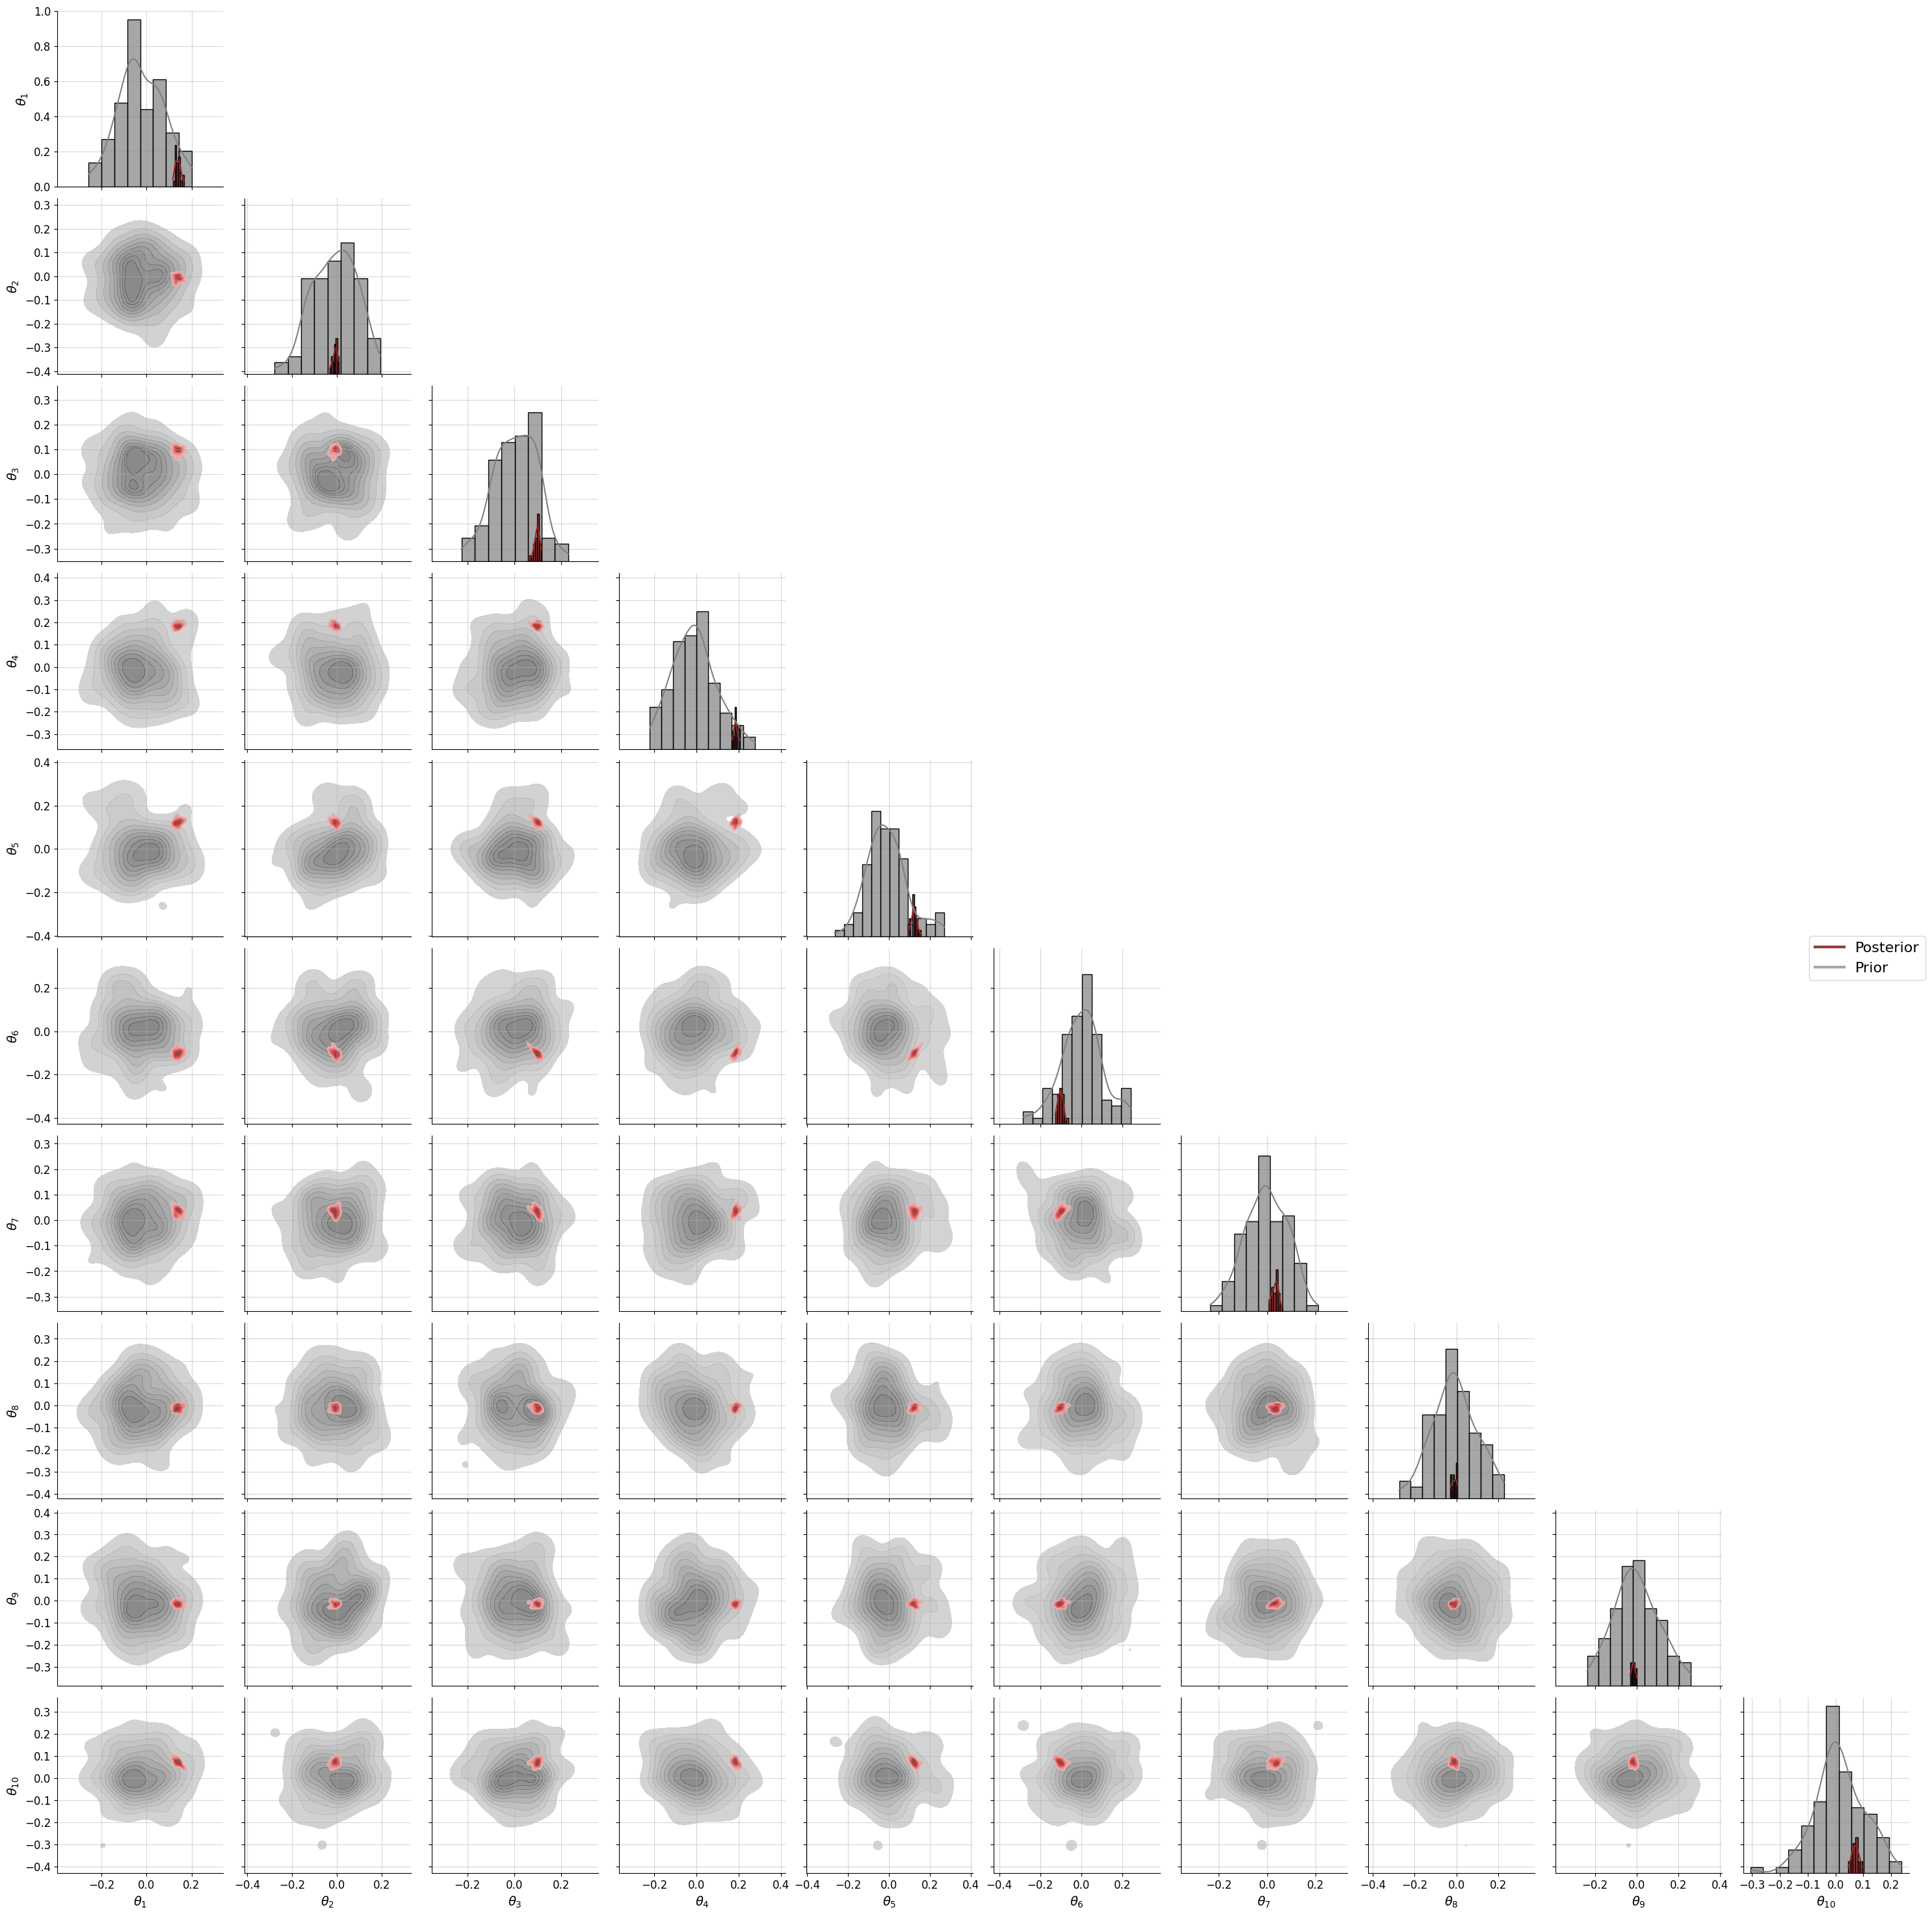

In [70]:
diagnostics.plot_posterior_2d(test_sample, prior_draws=true_params);

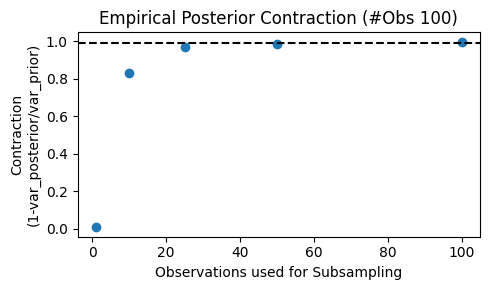

In [71]:
# plot contraction factor
prior_var = prior.scale**2

# contraction =  1 - posterior_var / prior_var
true_contraction = posterior_contraction(prior_std, likelihood_std, data_sizes[0]).mean(axis=-1)
contractions = 1 - np.array(list(posterior_var.values())).mean(axis=-1) / prior_var.mean(axis=-1)

plt.figure(figsize=(5, 3), tight_layout=True)
plt.scatter([100, 1, 10, 25, 50], contractions)
plt.axhline(true_contraction, color='black', linestyle='--')
plt.title(f'Empirical Posterior Contraction (#Obs {data_sizes[0]})')
plt.xlabel('Observations used for Subsampling')
plt.ylabel('Contraction\n(1-var_posterior/var_prior)')
plt.show()